# Code repository for producing results

Code for the Nature Human Behavior paper [The minute-scale dynamics of online emotions reveal the effects of affect labeling]() by Rui Fan, Onur Varol, Ali Varamesh, Alexander Barron, Ingrid van de Leemput, Marten Scheffer, and Johan Bollen

Correspondence to: jbollen@indiana.edu & buaafanrui@gmail.com



In [1]:
%matplotlib inline 

import glob
import numpy as np
import scipy as sp

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import pandas as pd

from scipy import stats
from scipy.optimize import curve_fit

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from lmfit.models import *
from sklearn.mixture import GaussianMixture


In [2]:
# Folder for intermediary files created by processing raw tweet files. 
DATA_PATH = 'data/intermediary_data/'


# Volume graph 

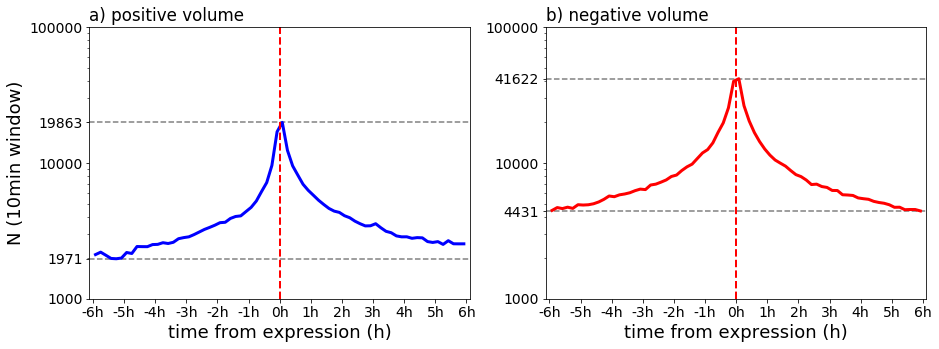

In [5]:
# Read positive and negative valence timeseries VADER and null-models
pos_all = pd.read_csv("{}pos_all.txt".format(DATA_PATH), sep="\t")
neg_all = pd.read_csv("{}neg_all.txt".format(DATA_PATH), sep="\t")

plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams.update({'font.size': 14})

datasets = [pos_all, neg_all]
labels = ["a) positive volume", "b) negative volume" ]
colors = ["blue", "red"]

fig, axes = plt.subplots(1, 2)
for i in range(len(axes)):
    data = datasets[i]
    label = labels[i]
    color = colors[i]
    
    # set up axes and labels
    axes[i].set_xlim([-22000, 22000])
    axes[i].set_xlabel("time from expression (h)", fontsize=18)
    
    if i == 0:
        axes[i].set_ylabel("N (10min window)", fontsize=18)
    axes[i].set_title(label, loc="left")
    axes[i].set_yscale('log')
    
    # determine max and min
    nmax = np.max(data["lengths"])
    nmin = np.min(data["lengths"])
    axes[i].set_ylim(nmin*0.85,nmax*1.25)
    
    # add horizontal line
    axes[i].axhline(y=nmax, color="gray",linestyle="--")
    axes[i].axhline(y=nmin,color="gray",linestyle="--")
           
    plt.sca(axes[i])
    plt.xticks([i*60*60 for i in range(-6,7)], [str(i)+'h' for i in range(-6,7)])
    
    axes[i].plot(data["window"], data["lengths"], linewidth=3, label="volume", color=color)
    axes[i].axvline(x=0, color="red", linestyle="--", linewidth=2)
    #axes[i].grid(which="both")
    
    axes[i].set_yticks([1000, nmin, 10000, nmax,100000])
    axes[i].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    
#fig.savefig('figures/tweet_volume_windowt.pdf', bbox_inches='tight')
fig.savefig('figures/FigS3.pdf', bbox_inches='tight')


**Supplementary Figure 2 Number of tweets per time window.** We observe significantly higher volumes of tweets across our sample of individuals closer to the time of affect labeling.  (a) The sample of tweets in the positive group ranges from a minimum of 1,971 to a maximum of 19,863 tweets. (b) The sample of tweets in the negative group ranges from a minimum of 4,431 to a maximum of 41,622 tweets. Note that we find a significant larger volume of tweets in the negative group vs. the positive group.

# CUSUM Analysis

Mean value a) positive: 0.13
Mean value b) negative: 0.11


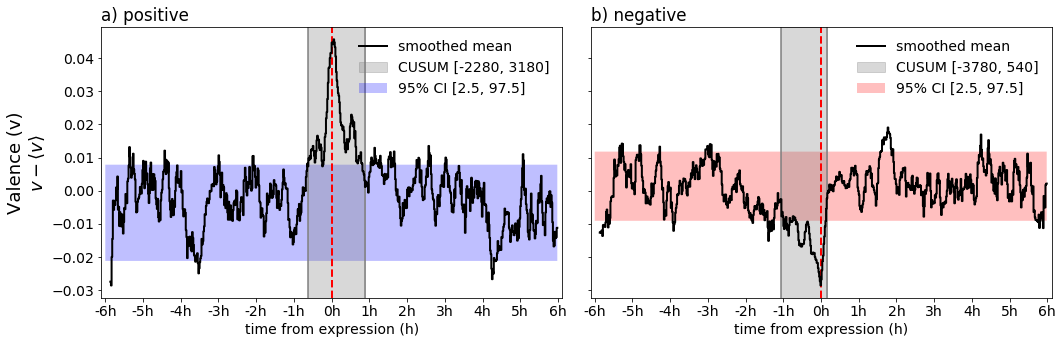

In [6]:
def find_abnormal(data, mean, k):
    # find abnormal values
    N = len(data)
    smax, smin = 0, 0
    maxs, mins = [], []
    for i in range(N):
        new_max = max(0, smax+data[i]-mean-k)
        new_min = min(0, smin+data[i]-mean+k)
        smin = new_min
        smax = new_max
        maxs.append(smax)
        mins.append(smin)
    return maxs, mins

def find_abnormal_max(maxs, H, len_sub_seq):
    # find continuous abnormal values
    l_max_abnormals = []
    i = 0
    while i < len(maxs):
        j = i
        while j < len(maxs):
            if maxs[j] > H:
                break
            j += 1
        abnormals = [j]
        while j+1 < len(maxs) and maxs[j] < maxs[j+1]:
            j += 1
            abnormals.append(j)
        j += 1
        i = j
        if len(abnormals) >= len_sub_seq:
            l_max_abnormals.append(abnormals)
    return l_max_abnormals

def find_abnormal_min(mins, H, len_sub_seq):
    # find continuous abnormal values
    l_min_abnormals = []
    i = 0
    while i < len(mins):
        j = i
        while j < len(mins):
            if mins[j] < -H:
                break
            j += 1
        abnormals = [j]
        while j+1 < len(mins) and mins[j] > mins[j+1]:
            j += 1
            abnormals.append(j)
        j += 1
        i = j
        if len(abnormals) >= len_sub_seq:
            l_min_abnormals.append(abnormals)
    return l_min_abnormals

# Read mean valence time series
mood_pos_all = pd.read_csv("{}mean_mood=1_window=60_gender=all.txt".format(DATA_PATH), sep="\t")
mood_neg_all = pd.read_csv("{}mean_mood=-1_window=60_gender=all.txt".format(DATA_PATH), sep="\t")

# set figure size parameters
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams.update({'font.size': 14})

# changing graph parameters
datasets = [mood_pos_all, mood_neg_all]
labels = ["a) positive", "b) negative" ]
colors = ["blue", "red"]

fig, axes = plt.subplots(1,2, sharey=True)
for i in range(len(axes)):
    
    # get plotting parameters
    data = datasets[i]
    label = labels[i]
    color = colors[i]
    
    # set up graph labels and axes
    axes[i].set_title(label, loc="left")
    
    # set axis limits and labels
    axes[i].set_xlim([-22000, +22000])
    axes[i].set_xlabel("time from expression (h)")
    if i == 0:
        axes[i].set_ylabel("Valence (v)\n" + r"$v - \left \langle v \right \rangle$", fontsize=18)
    
    #set tick marks to 3600s = an hour
    plt.sca(axes[i])
    plt.xticks([i*60*60 for i in range(-6,7)], [str(i)+'h' for i in range(-6,7)])
        
    mean_smoothed = data["mean"].rolling(window=10).mean()
    print('Mean value {}: {:.2f}'.format(labels[i], data["mean"].mean()))
    mean_smoothed -= np.mean(mean_smoothed)
        
    # CUSUM mark emotional period
    mean, std = np.mean(mean_smoothed.iloc[-180:]), np.std(mean_smoothed.iloc[-180:])
    maxs, mins = find_abnormal(mean_smoothed, mean, std)
    
    if i == 0:
        abnormal_points = find_abnormal_max(maxs, 0.01, 40)
    else:
        abnormal_points = find_abnormal_min(mins, 0.01, 40)
        
    cusum_start = data.iloc[min(list(abnormal_points[0]))]["start"]
    cusum_end = data.iloc[max(list(abnormal_points[0]))]["start"]
    
    cusumlabel = "CUSUM [{}, {}]".format(int(cusum_start), int(cusum_end))
    axes[i].axvspan(cusum_start, cusum_end, alpha=0.3, color='gray', label=cusumlabel)
    axes[i].axvline(x=cusum_start, color="gray")
    axes[i].axvline(x=cusum_end, color="gray")
    axes[i].axvline(x=0, color="red", linestyle="--", linewidth=2)
    
    # CI BAND: mark horizontal bamd of percentiles of magnitude of SMOOTHED time series
    plow, phigh = 2.5,97.5
    band_low, ts_median, band_high = np.nanpercentile(mean_smoothed.iloc[-180:], plow),\
                                     np.nanpercentile(mean_smoothed.iloc[-180:], 50.0),\
                                     np.nanpercentile(mean_smoothed.iloc[-180:], phigh)
            
    axes[i].fill_between(data["start"], band_low, band_high, 
                         alpha=0.25, facecolor=color,
                         label="95% CI [{}, {}]".format(plow,phigh), 
                         step="mid")
    
    axes[i].step(data["start"], mean_smoothed,\
            color="black", linewidth=2, 
            label="smoothed mean")
    axes[i].legend(frameon=False, prop={'size': 14})

plt.tight_layout()
#fig.savefig('figures/posneg_all_1minute_CUSUM.pdf', bbox_inches='tight')
fig.savefig('figures/Fig2.pdf', bbox_inches='tight')


**Figure 2 Time series of observed valence values across all individuals.** Mean-centered time series of observed alence values in 1 minute increments, smoothed by a 10 minute rolling average (positive N=42,627 and negative N=67,316), for positive (a) and negative (b) affect labeling group. The time range extends from 6 hours before to 6 hours after individuals explicitly express experiencing an emotion at time t0. The emotional expressions themselves at time t0 are excluded from this analysis and we do not analyze timelines that contain more than 1 explicit emotional expression within a 48 hour span. We use the first 3 hours to estimate a baseline 95% CI for the entire time series (horizontal gray bar). A CUSUM test is used to detect statistically significant change points in the resulting time series. A gray vertical bar marks where a CUSUM analysis indicates significant change point based on the time series' cumulative variance. Time series are mean-centered by subtracting the time series' mean over the 12 hours span (see Supplementary Figure 3 for raw time series showing different in positive and negative time series' baselines).

Mean value a) positive: 0.13
Mean value b) negative: 0.11


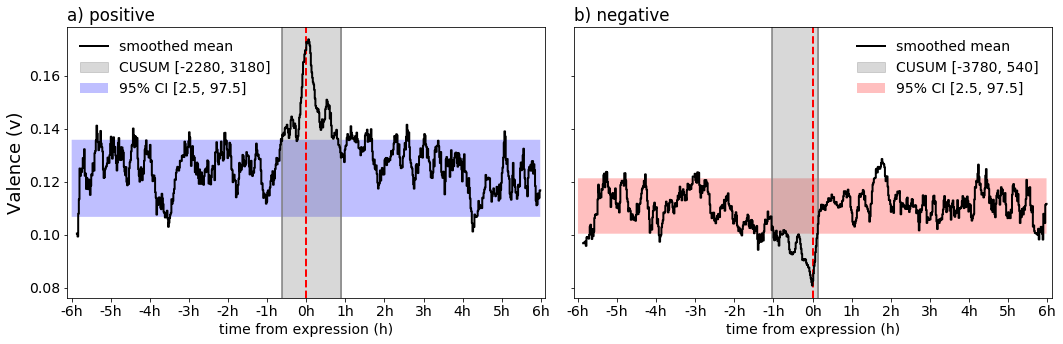

In [7]:

# Read mean valence time series
mood_pos_all = pd.read_csv("{}mean_mood=1_window=60_gender=all.txt".format(DATA_PATH), sep="\t")
mood_neg_all = pd.read_csv("{}mean_mood=-1_window=60_gender=all.txt".format(DATA_PATH), sep="\t")

# set figure size parameters
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams.update({'font.size': 14})

# changing graph parameters
datasets = [mood_pos_all, mood_neg_all]
labels = ["a) positive", "b) negative" ]
colors = ["blue", "red"]

fig, axes = plt.subplots(1,2, sharey=True)
for i in range(len(axes)):
    
    # get plotting parameters
    data = datasets[i]
    label = labels[i]
    color = colors[i]
    
    # set up graph labels and axes
    axes[i].set_title(label, loc="left")
    
    # set axis limits and labels
    axes[i].set_xlim([-22000, +22000])
    axes[i].set_xlabel("time from expression (h)")
    if i == 0:
        axes[i].set_ylabel("Valence (v)", fontsize=18)
    
    #set tick marks to 3600s = an hour
    plt.sca(axes[i])
    plt.xticks([i*60*60 for i in range(-6,7)], [str(i)+'h' for i in range(-6,7)])
    
    mean_smoothed = data["mean"].rolling(window=10).mean()
    print('Mean value {}: {:.2f}'.format(labels[i], data["mean"].mean()))
    
    # CUSUM mark emotional period
    mean, std = np.mean(mean_smoothed.iloc[-180:]), np.std(mean_smoothed.iloc[-180:])
    maxs, mins = find_abnormal(mean_smoothed, mean, std)
    
    if i == 0:
        abnormal_points = find_abnormal_max(maxs, 0.01, 40)
    else:
        abnormal_points = find_abnormal_min(mins, 0.01, 40)
        
    cusum_start = data.iloc[min(list(abnormal_points[0]))]["start"]
    cusum_end = data.iloc[max(list(abnormal_points[0]))]["start"]
    
    cusumlabel = "CUSUM [{}, {}]".format(int(cusum_start), int(cusum_end))
    axes[i].axvspan(cusum_start, cusum_end, alpha=0.3, color='gray', label=cusumlabel)
    axes[i].axvline(x=cusum_start, color="gray")
    axes[i].axvline(x=cusum_end, color="gray")
    axes[i].axvline(x=0, color="red", linestyle="--", linewidth=2)
    
    # CI BAND: mark horizontal bamd of percentiles of magnitude of SMOOTHED time series
    plow, phigh = 2.5,97.5
    band_low, ts_median, band_high = np.nanpercentile(mean_smoothed.iloc[-180:], plow),\
                                     np.nanpercentile(mean_smoothed.iloc[-180:], 50.0),\
                                     np.nanpercentile(mean_smoothed.iloc[-180:], phigh)
            
    #print "percentiles: ", band_low, ts_median, band_high
    axes[i].fill_between(data["start"], band_low, band_high, 
                         alpha=0.25, facecolor=color,
                         #label="observed 95% CI[" + str(plow) + "," + str(phigh) + "]", 
                         label="95% CI [{}, {}]".format(plow,phigh), 
                         step="mid")
 
    axes[i].step(data["start"], mean_smoothed,\
            color="black", linewidth=2, 
            label="smoothed mean")

    axes[i].legend(frameon=False, prop={'size': 14})

plt.tight_layout()
#fig.savefig('figures/posneg_all_1minute_CUSUMv2.pdf', bbox_inches='tight')
fig.savefig('figures/Fig2v2.pdf', bbox_inches='tight')


**Supplementary Figure 3 Time series of mean valence for positive and negative affect labeling group over time with CUSUM determined change points and  95% confidence intervals for variance.**  (a) The time series of mean valence values ranges from 6 hours before the time of affect labeling (t=0 hours) to 6 hours after. The blue band indicates the 95% confidence interval determined from the time series variance values in the first 3 hours ([t0-6hours,t0-3hours]). The time series remains within the 95% confidence interval for most of the period under consideration with the exception of the area indicated by the vertical gray area which shows the time period detected by the CUSUM method. This is the period in the time series where mean valence values are determined to undergo a positive change point. (b) A similar analysis conducted for the negative affect labeling group. The red horizontal bar indicates the  95% confidence interval determined from the time series variance in the first 3 hours ([t0-6hours,t0-3hours]). The time series remains within the 95% confidence interval for most of the period under consideration with the exception of the area indicated by the vertical gray area which shows the time period detected by the CUSUM method. This is the period in the time series where mean valence values are determined to undergo a negative change point.

Mean value a) positive female valence: 0.16
a) positive female valence CUSUM: max:  -2460.0 s-  3180.0 s
percentiles:  -0.03032088857243318 -0.005575513572433147 0.012200343927566852
Mean value b) negative female valence: 0.13
b) negative female valence CUSUM: max:  -2640.0 s-  420.0 s
percentiles:  -0.02014828062236281 0.0035963668776370916 0.02508003937763712
Mean value c) positive male valence: 0.10
c) positive male valence CUSUM: max:  -2880.0 s-  2940.0 s
percentiles:  -0.030003611023206738 -0.00710114852320675 0.02234432147679327
Mean value d) negative male valence: 0.09
d) negative male valence CUSUM: max:  -1920.0 s-  480.0 s
percentiles:  -0.01851818386075941 0.001822041139240553 0.020173488639240567


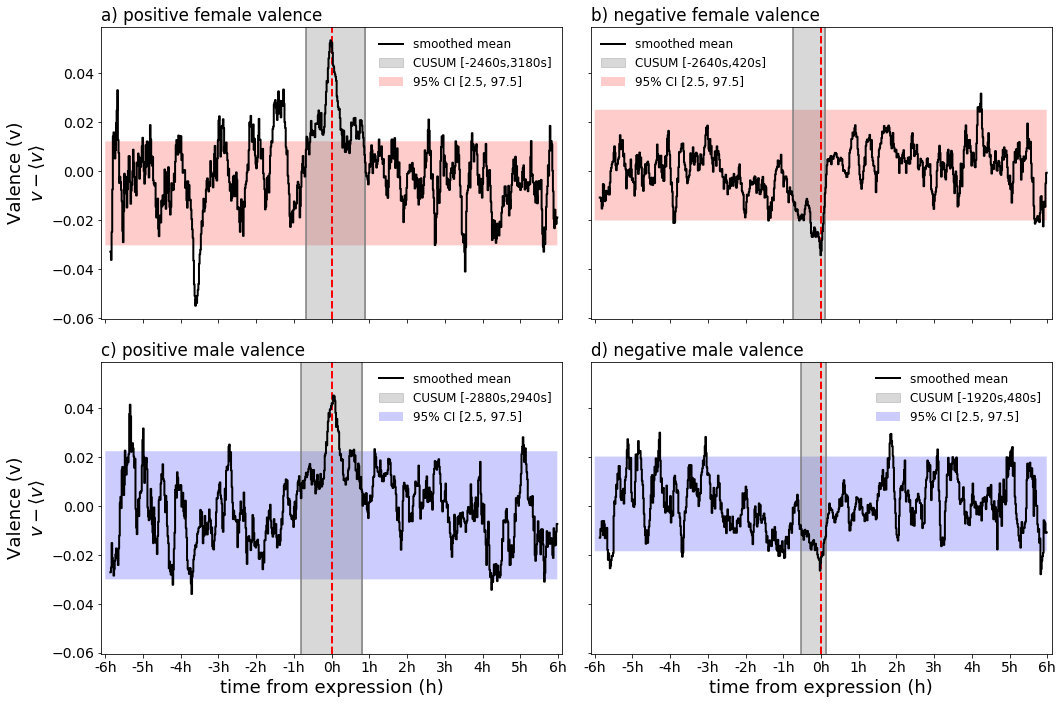

In [8]:
plt.rcParams['figure.figsize'] = (15.0, 10.0)
plt.rcParams.update({'font.size': 14})

files = ['mean_mood=1_window=60_gender=female.txt',\
         'mean_mood=-1_window=60_gender=female.txt',\
         'mean_mood=1_window=60_gender=male.txt',\
         'mean_mood=-1_window=60_gender=male.txt']

mood_pos_male = pd.read_csv("{}mean_mood=1_window=60_gender=male.txt".format(DATA_PATH), sep="\t")
mood_neg_male = pd.read_csv("{}mean_mood=-1_window=60_gender=male.txt".format(DATA_PATH), sep="\t")
mood_pos_female = pd.read_csv("{}mean_mood=1_window=60_gender=female.txt".format(DATA_PATH), sep="\t")
mood_neg_female = pd.read_csv("{}mean_mood=-1_window=60_gender=female.txt".format(DATA_PATH), sep="\t")

datasets = [mood_pos_female, mood_neg_female, mood_pos_male, mood_neg_male]
labels = ["a) positive female valence", "b) negative female valence",
          "c) positive male valence",   "d) negative male valence"]

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
for i,ax in enumerate([axes[0][0], axes[0][1], axes[1][0], axes[1][1]]):

    data = datasets[i]
    label = labels[i]
    color = ['red' if 'female' in label else 'blue']
    
    # set up graph labels and axes
    ax.set_title(label, loc="left")
    
    # set axis limits and labels
    ax.set_xlim([-22000, 22000])
    if i in [2,3]:
        ax.set_xlabel("time from expression (h)", fontsize=18)
    if i in [0,2]:
        ax.set_ylabel("Valence (v)\n" + r"$v - \left \langle v \right \rangle$", fontsize=18)
    
    plt.sca(ax)
    plt.xticks([i*60*60 for i in range(-6,7)], [str(i)+'h' for i in range(-6,7)])
        
    mean_smoothed = data["mean"].rolling(window=10).mean()
    print('Mean value {}: {:.2f}'.format(labels[i], data["mean"].mean()))
    mean_smoothed -= np.mean(mean_smoothed)
        
    # emotional period indication based on CUSUM
    mean, std = np.mean(mean_smoothed.iloc[-180:]), np.std(mean_smoothed.iloc[-180:])
    maxs, mins = find_abnormal(mean_smoothed, mean, std)
    
    if "positive" in label:
        abnormal_points = find_abnormal_max(maxs, 0.01, 40)
    else:
        abnormal_points = find_abnormal_min(mins, 0.01, 40)
        
    cusum_start = data.iloc[min(list(abnormal_points[0]))]["start"]
    cusum_end = data.iloc[max(list(abnormal_points[0]))]["start"]
    print(label, "CUSUM: max: ", cusum_start, "s- ", cusum_end, "s")
    cusumlabel = "CUSUM ["+str(int(cusum_start))+"s,"+str(int(cusum_end))+"s]"
    
    ax.axvspan(cusum_start, cusum_end, alpha=0.3, color='gray', label=cusumlabel)
    ax.axvline(x=cusum_start, color="gray")
    ax.axvline(x=cusum_end, color="gray")
    ax.axvline(x=0, color="red", linestyle="--", linewidth=2)
    
    # indicate band of percentiles of magnitude of SMOOTHED time series
    plow, phigh = 2.5,97.5
    band_low, ts_median, band_high = np.nanpercentile(mean_smoothed.iloc[-180:], plow),\
                                     np.nanpercentile(mean_smoothed.iloc[-180:], 50.0),\
                                     np.nanpercentile(mean_smoothed.iloc[-180:], phigh)
            
    print("percentiles: ", band_low, ts_median, band_high)
    ax.fill_between(data["start"], band_low, band_high,
                    alpha=0.2, facecolor=color,
                    label="95% CI [{}, {}]".format(plow, phigh), step="mid")
      
    ax.step(data["start"], mean_smoothed,
            color="black", linewidth=2, label="smoothed mean")
    
    ax.legend(frameon=False, prop={'size': 12})

plt.tight_layout()
#fig.savefig('figures/posneg_female_male_1minute_CUSUM.pdf', bbox_inches='tight')
fig.savefig('figures/FigS2.pdf', bbox_inches='tight')


**Supplementary Figure 5: Gender differentiated positive and negative valence timeseries.** Gender differentiated time series of mean valence values in adjacent 1 minute windows before and after an explicit expression of having a positive or negative emotion at time t0. Time series are smoothed by a 10 minute rolling average. The blue and red bands shows a 95% confidence intervals of the distribution of valence values determined from the first 3 hours of the time series. A CUSUM test reveals where statistically significant changes in the time series occur (vertical gray bands).

# Curve fitting for valence curves

a) positive valence => Error: 0.0013302829043208766
b) negative valence => Error: 0.00046907796951851417


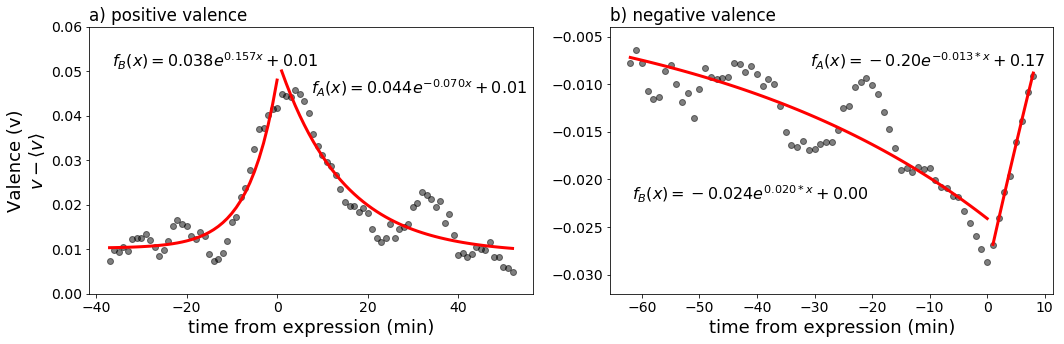

In [9]:
def exp(x, N, lam, b):
    return N * np.e**(lam*(x)) + b

plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams.update({'font.size': 14})

# Read mean valence time series
mood_pos_all = pd.read_csv("{}mean_mood=1_window=60_gender=all.txt".format(DATA_PATH), sep="\t")
mood_neg_all = pd.read_csv("{}mean_mood=-1_window=60_gender=all.txt".format(DATA_PATH), sep="\t")

datasets = list([mood_pos_all, mood_neg_all])
labels = ["a) positive valence", "b) negative valence" ]
startEnd = [(-2280/60, 3180/60), (-3780/60, 540/60)]
fig, axes = plt.subplots(1,2)
for i in range(len(axes)):
    data = datasets[i]
    
    data["start"] = data["start"] / 60. # Seconds to minutes
    data["mean_smoothed"] = data["mean"].rolling(window=10).mean()
    data["mean_smoothed"] -= np.mean(data["mean_smoothed"])
    
    mask = (startEnd[i][0] < data["start"]) & (data["start"] < startEnd[i][1])
    axes[i].scatter(data.loc[mask]["start"], data.loc[mask]["mean_smoothed"], color='k', alpha=0.5)
    
    maskb = (startEnd[i][0] < data["start"]) & (data["start"] <= 0)
    fit_xb = data.loc[maskb]["start"]
    fit_yb = data.loc[maskb]["mean_smoothed"]
    
    maska = (0 < data["start"]) & (data["start"] < startEnd[i][1])
    fit_xa = data.loc[maska]["start"]
    fit_ya = data.loc[maska]["mean_smoothed"]
    
    if i == 0:
        error = 0
        popt, pcov = curve_fit(exp, fit_xb, fit_yb, bounds=([0, 0, -np.inf], [np.inf, 1, np.inf]))
        axes[i].plot(fit_xb, exp(fit_xb, *popt), color='r', linestyle='-', linewidth=3)
        axes[i].text(0.05, 0.85, r'$f_B(x)=%.3fe^{%.3fx}+%.2f$' % tuple(popt), 
                     fontsize=16, transform=axes[i].transAxes)
        error += np.sum((exp(fit_xb, *popt) - np.array(fit_yb)) ** 2)
        
        popt, pcov = curve_fit(exp, fit_xa, fit_ya, bounds=([-np.inf, -1, -np.inf], [np.inf, 0, np.inf]))
        axes[i].plot(fit_xa, exp(fit_xa, *popt), color='r', linestyle='-', linewidth=3)
        axes[i].text(0.5, 0.75, r'$f_A(x)=%.3fe^{%.3fx}+%.2f$' % tuple(popt), 
                     fontsize=16, transform=axes[i].transAxes)
        error += np.sum((exp(fit_xa, *popt) - np.array(fit_ya)) ** 2)
        print('{} => Error: {}'.format(labels[i], error))
        
    if i == 1:
        error = 0
        popt, pcov = curve_fit(exp, fit_xb, fit_yb, bounds=([-np.inf, 0, 0], [np.inf, 1, 1]))
        axes[i].plot(fit_xb, exp(fit_xb, *popt), color='r', linewidth=3)
        axes[i].text(0.05, 0.35, r'$f_B(x)=%.3fe^{%.3f*x}+%.2f$' % tuple(popt), 
                 fontsize=16, transform=axes[i].transAxes)
        error += np.sum((exp(fit_xb, *popt) - np.array(fit_yb)) ** 2)
        
        popt, pcov = curve_fit(exp, fit_xa, fit_ya, bounds=([-1, -1, -np.inf], [0, 0, np.inf]))
        axes[i].plot(fit_xa, exp(fit_xa, *popt), color='r', linewidth=3)
        axes[i].text(0.45, 0.85, r'$f_A(x)=%.2fe^{%.3f*x}+%.2f$' % tuple(popt),
                 fontsize=16, transform=axes[i].transAxes)
        error += np.sum((exp(fit_xa, *popt) - np.array(fit_ya)) ** 2)
        print('{} => Error: {}'.format(labels[i], error))
    
    axes[i].set_title(labels[i], loc="left")
    axes[i].set_xlabel("time from expression (min)", fontsize=18)
    if i == 0:
        axes[i].set_ylabel("Valence (v)\n" + r"$v - \left \langle v \right \rangle$", fontsize=18)
    
axes[1].set_ylim(ymin=-0.032, ymax=-0.004)
axes[0].set_ylim(ymin=0)
    
plt.tight_layout()
#fig.savefig('figures/fitting_pos_neg_all_1min.pdf', bbox_inches='tight')
fig.savefig('figures/Fig3.pdf', bbox_inches='tight')


**Figure 3: Curve fitting results of the smoothed mean Valence values.** (a) The time series of smoothed mean valence values for the positive affect labeling group reveals a sharp peak and reversal at time $t_0$. The ramp-up and ramp-down of both positive and negative time series is best fitted by 2 separate exponential growth and decay functions before and after the affect labeling at time $t_0$ respectively (See Supplemental Information). The ramp-up and ramp down of positive valence is best fit with the functions $f_B(t<t_0) = 0.038e^{0.157t}$ and $f_A(t>t_0) = 0.044e^{-0.07t}+0.01$. (b) The time series of smoothed mean valence values for the negative affect labeling group also reveals a sharp peak and reversal at time $t_0$. The ramp-down and ramp-up of negative valence (b) is best fit with the functions $f_B(t<t_0) = -0.024e^{0.020t}$ and $f_A(t>t_0) = -0.020e^{-0.013t} + 0.17$.

**Supplementary Table 1** Sum of Squared Errors (SSE) for multiple functions that were fit against the ramp-up and ramp-down of positive and negative Valence, in rank-order of lowest SSE (marked *). Best fit is achieved with two separate exponential growth and decay functions, i.e. one before and one after t0, as shown in Fig.3

In [10]:
# Read mean valence time series
mood_pos_all = pd.read_csv("{}mean_mood=1_window=60_gender=all.txt".format(DATA_PATH), sep="\t")
mood_neg_all = pd.read_csv("{}mean_mood=-1_window=60_gender=all.txt".format(DATA_PATH), sep="\t")

datasets = list([mood_pos_all, mood_neg_all])
labels = ['positive', 'negative']
startEnd = [(-2280/60, 3180/60), (-3780/60, 540/60)]

for i,data in enumerate(datasets):
    print('\t### {} ###'.format(labels[i]))
    data["start"] = data["start"] / 60. # Seconds to minutes
    data["mean_smoothed"] = data["mean"].rolling(window=10).mean()
    data["mean_smoothed"] -= np.mean(data["mean_smoothed"])
    
    mask = (startEnd[i][0] < data["start"]) & (data["start"] < startEnd[i][1])
    fit_x, fit_y = data.loc[mask]["start"].values, data.loc[mask]["mean_smoothed"].values
    for ffunc in [GaussianModel, LorentzianModel, QuadraticModel]:
        print('\n=> {}'.format(ffunc))
        
        model = ffunc()
        params = model.make_params()
        result = model.fit(fit_y, params, x=fit_x, nan_policy='omit')
        print(result.fit_report())
        error = np.sum((np.array(result.best_fit) - np.array(fit_y)) ** 2)
        print('Error: {}'.format(error))


	### positive ###

=> <class 'lmfit.models.GaussianModel'>
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 69
    # data points      = 90
    # variables        = 3
    chi-square         = 0.00449573
    reduced chi-square = 5.1675e-05
    Akaike info crit   = -885.399410
    Bayesian info crit = -877.899981
[[Variables]]
    sigma:      21.3471573 +/- 1.18348078 (5.54%) (init = 1)
    center:     5.66882442 +/- 1.11272004 (19.63%) (init = 0)
    amplitude:  1.72478533 +/- 0.07965006 (4.62%) (init = 1)
    fwhm:       50.2687129 +/- 2.78688422 (5.54%) == '2.3548200*sigma'
    height:     0.03223332 +/- 0.00145670 (4.52%) == '0.3989423*amplitude/max(1.e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, amplitude) =  0.618

Error: 0.004495725493690082

=> <class 'lmfit.models.LorentzianModel'>
[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   

# Analyzing confidence intervals of observations and null-model


 a) positive valence
Vader mean:0.13 | Null mean:0.13
max window_end a) positive valence : -300 s
min window_end a) positive valence : -21300 s
> NULL:
 35   -300
36    300
37    900
Name: window, dtype: int64
< NULL
 Series([], Name: window, dtype: int64)

 b) negative valence
Vader mean:0.11 | Null mean:0.11
max window_end b) negative valence : 6300 s
min window_end b) negative valence : -300 s
> NULL:
 Series([], Name: window, dtype: int64)
< NULL
 32   -2100
34    -900
35    -300
Name: window, dtype: int64


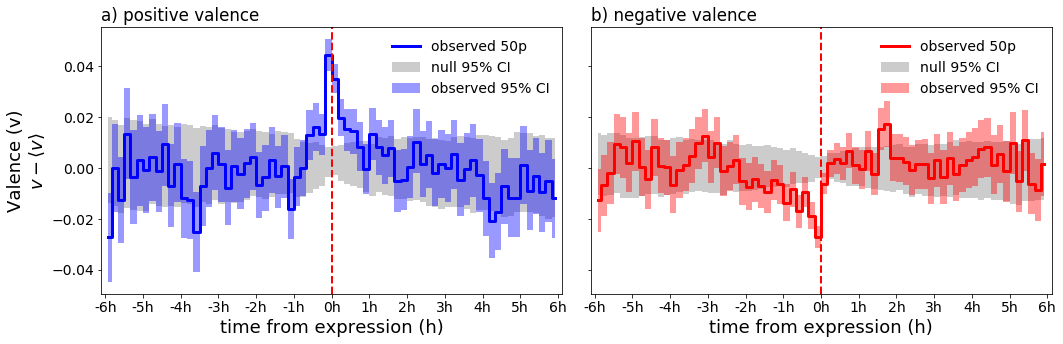

In [11]:
# set figure size parameters
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams.update({'font.size': 14})

# Read positive and negative valence timeseries VADER and null-models
pos_all = pd.read_csv("{}pos_all.txt".format(DATA_PATH), sep="\t")
neg_all = pd.read_csv("{}neg_all.txt".format(DATA_PATH), sep="\t")

datasets = [pos_all, neg_all]
labels = ["a) positive valence", "b) negative valence" ]
colors = ["blue", "red"]

fig, axes = plt.subplots(1,2, sharey=True)
for i in range(len(axes)):
    
    data = datasets[i]
    label = labels[i]
    color = colors[i]
    
    # Mean difference
    meanVader = data["vader_50p"].mean()
    data["vader_50p"] -= meanVader
    data["vader_2.5p"] -= meanVader
    data["vader_97.5p"] -= meanVader
    meanNull = data["null_50p"].mean()
    data["null_50p"] -= meanNull
    data["null_2.5p"] -= meanNull
    data["null_97.5p"] -= meanNull

    # get index of maximum value
    maxv = np.argmax(data["vader_50p"].values)
    minv = np.argmin(data["vader_50p"].values)
    
    #### EMOTIONAL PERIOD BASED ON NON-OVERLAPPING CI
    # find area where CIs don't overlap, i.e. where vader_2.5p > null_97.5p
    # or where vader_97.5p < null_2.5p
    print("\n", label)
    print('Vader mean:{:.2f} | Null mean:{:.2f}'.format(meanVader, meanNull))
    print("max window_end", label, ":", data["window"].iloc[maxv], "s")
    print("min window_end", label, ":", data["window"].iloc[minv], "s")
    print("> NULL:\n", data[data["vader_2.5p"] > data["null_97.5p"]]["window"])
    print("< NULL\n", data[data["vader_97.5p"] < data["null_2.5p"]]["window"])

    # set up graph labels and axes
    axes[i].set_title(label, loc="left")
    
    # set axis limits and labels
    axes[i].set_xlim([-22000, +22000])
    axes[i].set_xlabel("time from expression (h)", fontsize=18)
    if i == 0:
        axes[i].set_ylabel("Valence (v)\n" + r"$v - \left \langle v \right \rangle$", fontsize=18)
    
    #set tick marks to 3600s = an hour
    plt.sca(axes[i])
    plt.xticks([i*60*60 for i in range(-6,7)], [str(i)+'h' for i in range(-6,7)])
    
    ## TIME SERIES
    # null bands and lines
    axes[i].fill_between(data["window"], data["null_2.5p"], data["null_97.5p"],
                         alpha=0.4, facecolor='gray', label="null 95% CI", step="mid")

    # valence bands and lines
    axes[i].fill_between(data["window"], data["vader_2.5p"], data["vader_97.5p"],
                         alpha=0.4, facecolor=color, label="observed 95% CI", step="mid")
    axes[i].step(data["window"], data["vader_50p"],
                 color=color, linewidth=3, label="observed 50p", where='mid')
    
    #axes[i].grid(which='both')
    axes[i].axvline(x=0, color="red", linestyle="--", linewidth=2)
    
    axes[i].legend(frameon=False, prop={'size': 14})
    
plt.tight_layout()
    
#fig.savefig('figures/posneg_all_10minute_KS.pdf', bbox_inches='tight')
fig.savefig('figures/FigS4.pdf', bbox_inches='tight')


 a) positive valence
Vader mean:0.13 | Null mean:0.13
max window_end a) positive valence : -300 s
min window_end a) positive valence : -21300 s
> NULL:
 35   -300
36    300
37    900
Name: window, dtype: int64
< NULL
 Series([], Name: window, dtype: int64)

 b) negative valence
Vader mean:0.11 | Null mean:0.11
max window_end b) negative valence : 6300 s
min window_end b) negative valence : -300 s
> NULL:
 Series([], Name: window, dtype: int64)
< NULL
 32   -2100
34    -900
35    -300
Name: window, dtype: int64


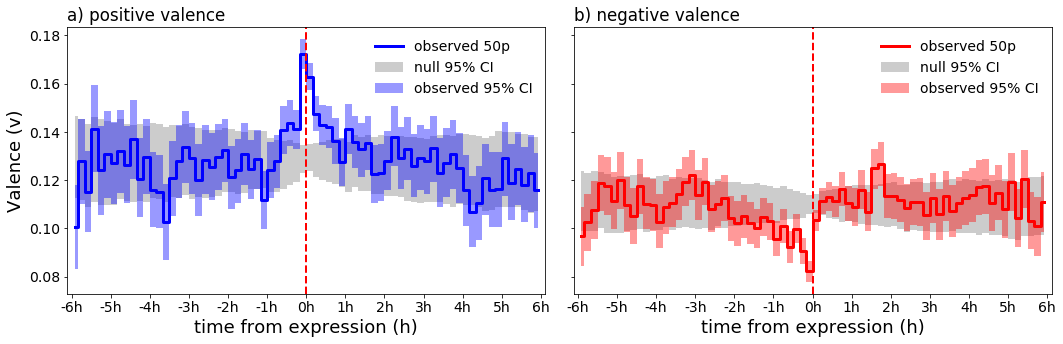

In [12]:
# set figure size parameters
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams.update({'font.size': 14})

# Read positive and negative valence timeseries VADER and null-models
pos_all = pd.read_csv("{}pos_all.txt".format(DATA_PATH), sep="\t")
neg_all = pd.read_csv("{}neg_all.txt".format(DATA_PATH), sep="\t")

datasets = [pos_all, neg_all]
labels = ["a) positive valence", "b) negative valence" ]
colors = ["blue", "red"]


fig, axes = plt.subplots(1,2, sharey=True)
for i in range(len(axes)):
    
    data = datasets[i]
    label = labels[i]
    color = colors[i]
    
    meanVader = data["vader_50p"].mean()
    meanNull = data["null_50p"].mean()

    # get index of maximum value
    maxv = np.argmax(data["vader_50p"].values)
    minv = np.argmin(data["vader_50p"].values)
    
    #### EMOTIONAL PERIOD BASED ON NON-OVERLAPPING CI
    # find area where CIs don't overlap, i.e. where vader_2.5p > null_97.5p
    # or where vader_97.5p < null_2.5p
    print("\n", label)
    print('Vader mean:{:.2f} | Null mean:{:.2f}'.format(meanVader, meanNull))
    print("max window_end", label, ":", data["window"].iloc[maxv], "s")
    print("min window_end", label, ":", data["window"].iloc[minv], "s")
    print("> NULL:\n", data[data["vader_2.5p"] > data["null_97.5p"]]["window"])
    print("< NULL\n", data[data["vader_97.5p"] < data["null_2.5p"]]["window"])

    # set up graph labels and axes
    axes[i].set_title(label, loc="left")
    
    # set axis limits and labels
    axes[i].set_xlim([-22000, +22000])
    axes[i].set_xlabel("time from expression (h)", fontsize=18)
    if i == 0:
        axes[i].set_ylabel("Valence (v)", fontsize=18)
    
    #set tick marks to 3600s = an hour
    plt.sca(axes[i])
    plt.xticks([i*60*60 for i in range(-6,7)], [str(i)+'h' for i in range(-6,7)])
    
    ## TIME SERIES
    # null bands and lines
    axes[i].fill_between(data["window"], data["null_2.5p"], data["null_97.5p"],
                         alpha=0.4, facecolor='gray', label="null 95% CI", step="mid")

    # valence bands and lines
    axes[i].fill_between(data["window"], data["vader_2.5p"], data["vader_97.5p"],
                         alpha=0.4, facecolor=color, label="observed 95% CI", step="mid")
    axes[i].step(data["window"], data["vader_50p"],
                 color=color, linewidth=3, label="observed 50p", where='mid')
    
    #axes[i].grid(which='both')
    axes[i].axvline(x=0, color="red", linestyle="--", linewidth=2)
    
    axes[i].legend(frameon=False, prop={'size': 14})
    
plt.tight_layout()
    
#fig.savefig('figures/posneg_all_10minute_KSv2.pdf', bbox_inches='tight')
fig.savefig('figures/FigS4v2.pdf', bbox_inches='tight')

**Supplementary Figure 4** Valence 95% confidence intervals vs the 95% confidence intervals of a null-model from 6 hours before to 6 hours after the time of affect labeling. (a) The 95% confidence intervals of positive valence levels overlap with the 95% confidence intervals of a null-model for most of the time before and after the time of affect labeling, with the exception of a short period (See Table 2 in main paper). (b)  The 95% confidence intervals of negative valence levels overlap with the 95% confidence intervals of a null-model for most of the time before and after the time of affect labeling, with the exception of a short period (See Table 2 in main paper).  Where the confidence intervals do not overlap we can infer that valence labels exceed chance levels predicted by our null-model.

[a) positive valence] Vader mean:0.13 | Null mean:0.13
max window_end a) positive valence : -300 s
min window_end a) positive valence : -21300 s
a) positive valence 

> NULL:
 35   -300
36    300
37    900
Name: window, dtype: int64
< NULL
 Series([], Name: window, dtype: int64)
[b) negative valence] Vader mean:0.11 | Null mean:0.11
max window_end b) negative valence : 6300 s
min window_end b) negative valence : -300 s
b) negative valence 

> NULL:
 Series([], Name: window, dtype: int64)
< NULL
 32   -2100
34    -900
35    -300
Name: window, dtype: int64


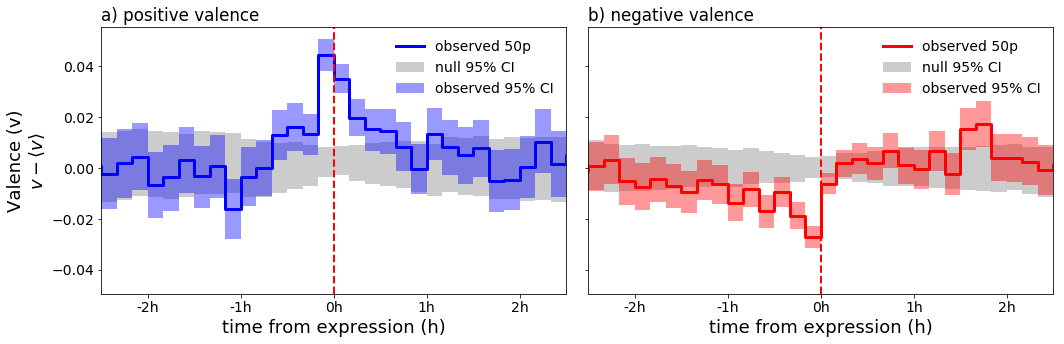

In [13]:
# set figure size parameters
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams.update({'font.size': 14})

# changing graph parameters
# Read positive and negative valence timeseries VADER and null-models
pos_all = pd.read_csv("{}pos_all.txt".format(DATA_PATH), sep="\t")
neg_all = pd.read_csv("{}neg_all.txt".format(DATA_PATH), sep="\t")

datasets = [pos_all, neg_all]
labels = ["a) positive valence", "b) negative valence" ]
colors = ["blue", "red"]

fig, axes = plt.subplots(1,2, sharey=True)

# loop through both figures each with its own axes, labels, etc
for i in range(len(axes)):

    # get next data file from files and labels, and plot these in the present ax in axes
    data = datasets[i]
    label = labels[i]
    color = colors[i]
    
    # Mean difference
    meanVader = data["vader_50p"].mean()
    data["vader_50p"] -= meanVader
    data["vader_2.5p"] -= meanVader
    data["vader_97.5p"] -= meanVader
    meanNull = data["null_50p"].mean()
    data["null_50p"] -= meanNull
    data["null_2.5p"] -= meanNull
    data["null_97.5p"] -= meanNull
    print('[{}] Vader mean:{:.2f} | Null mean:{:.2f}'.format(label, meanVader, meanNull))

    # get index of maximum value
    maxv = np.argmax(data["vader_50p"].values)
    minv = np.argmin(data["vader_50p"].values)
    
    print("max window_end", label, ":", data["window"].iloc[maxv], "s")
    print("min window_end", label, ":", data["window"].iloc[minv], "s")
    
    #### EMOTIONAL PERIOD BASED ON NON-OVERLAPPING CI
    # find area where CIs don't overlap, i.e. where vader_2.5p > null_97.5p
    # or where vader_97.5p < null_2.5p
    print(label, "\n")
    print("> NULL:\n", data[data["vader_2.5p"] > data["null_97.5p"]]["window"])
    print("< NULL\n", data[data["vader_97.5p"] < data["null_2.5p"]]["window"])

    
    # set up graph labels and axes
    axes[i].set_title(label, loc="left")
    
    # set axis limits and labels
    axes[i].set_xlim([-9000, +9000])
    axes[i].set_xlabel("time from expression (h)", fontsize=18)
    if i == 0:
        axes[i].set_ylabel("Valence (v)\n" + r"$v - \left \langle v \right \rangle$", fontsize=18)
    
    #set tick marks to 3600s = an hour
    plt.sca(axes[i])
    plt.xticks([-7200,-3600,0,3600,7200], [str(i)+'h' for i in range(-2,3)])
    
    ## TIME SERIES
    # null bands and lines
    axes[i].fill_between(data["window"], data["null_2.5p"],
                         data["null_97.5p"],
                         alpha=0.4, facecolor='gray', 
                         label="null 95% CI", step="mid")

    # valence bands and lines
    axes[i].fill_between(data["window"],
                         data["vader_2.5p"],
                         data["vader_97.5p"],
                         alpha=0.4, facecolor=color, 
                         label="observed 95% CI", step="mid")
    axes[i].step(data["window"], data["vader_50p"],
                 color=color, linewidth=3, label="observed 50p", where='mid')
    
    #axes[i].grid(which='both')
    axes[i].axvline(x=0, color="red", linestyle="--", linewidth=2)
    axes[i].legend(frameon=False, prop={'size': 14})
    
plt.tight_layout()
#fig.savefig('figures/posneg_all_10minute_KS_zoom3hr.pdf', bbox_inches='tight')
fig.savefig('figures/Fig4.pdf', bbox_inches='tight')


**Figure 4: Time series of observed valence confidence intervals vs. null-model confidence intervals at 10 minute increments.** Panel (a) compares the 95% confidence interval of bootstrapped mean valence values (blue bands) vs the 95% CI of a null-model (see Methods) of randomly chosen tweets (gray bands) for the range [−180', +180'] surrounding the moment of affect labeling at time $t_0$ (see Table 2). Confidence intervals do not overlap surrounding time $t_0$ indicating a statistically significant increase in positive valence. Panel (b) shows a similar comparison for negative valence indicating a statistically significant decrease of valence values surrounding time $t_0$ (see Table 2). Time series are mean-centered by subtracting the time series' mean over the 12 hours period shown. See Supplementary Figure 4 for raw time series.

[a) positive female valence] Vader mean:0.16 | Null mean:0.15
a) positive female valence 

> NULL:
 35   -300
36    300
Name: window, dtype: int64
< NULL
 Series([], Name: window, dtype: int64)
[b) positive male valence] Vader mean:0.10 | Null mean:0.10
b) positive male valence 

> NULL:
 35   -300
36    300
Name: window, dtype: int64
< NULL
 Series([], Name: window, dtype: int64)
[c) negative female valence] Vader mean:0.13 | Null mean:0.13
c) negative female valence 

> NULL:
 Series([], Name: window, dtype: int64)
< NULL
 32   -2100
34    -900
35    -300
Name: window, dtype: int64
[d) negative male valence] Vader mean:0.09 | Null mean:0.09
d) negative male valence 

> NULL:
 Series([], Name: window, dtype: int64)
< NULL
 35   -300
Name: window, dtype: int64


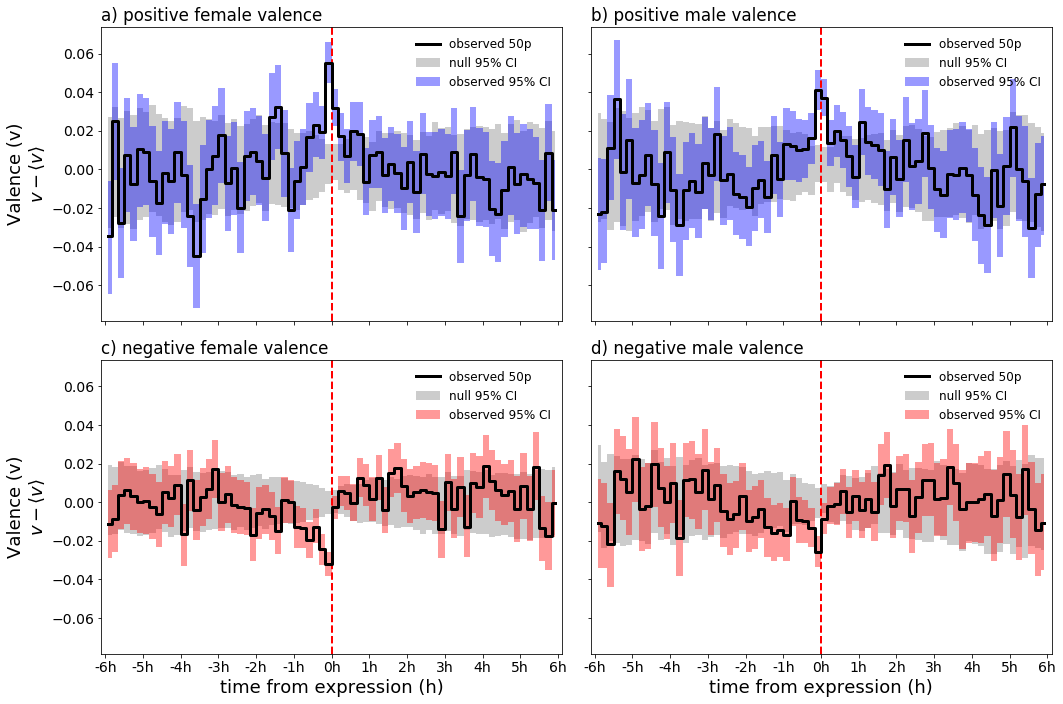

In [14]:
# Genders

pos_male = pd.read_csv("{}pos_male.txt".format(DATA_PATH), sep="\t")
neg_male = pd.read_csv("{}neg_male.txt".format(DATA_PATH), sep="\t")
pos_female = pd.read_csv("{}pos_female.txt".format(DATA_PATH), sep="\t")
neg_female = pd.read_csv("{}neg_female.txt".format(DATA_PATH), sep="\t")

plt.rcParams['figure.figsize'] = (15.0, 10.0)
plt.rcParams.update({'font.size': 14})

datasets = [pos_female, pos_male, neg_female, neg_male]
files = ['pos_female.txt', 'pos_male.txt', 'neg_female.txt', 'neg_male.txt', ]
labels = ["a) positive female valence", "b) positive male valence", 
          "c) negative female valence", "d) negative male valence"]

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
for i, ax in enumerate([axes[0][0], axes[0][1], axes[1][0], axes[1][1]]):        
    # get next data file from files and labels, and plot these in the present ax in axes
    data = datasets[i]
    label = labels[i]
    color = ['red' if 'negative' in label else 'blue']
    
    # Mean difference
    meanVader = data["vader_50p"].mean()
    data["vader_50p"] -= meanVader
    data["vader_2.5p"] -= meanVader
    data["vader_97.5p"] -= meanVader
    meanNull = data["null_50p"].mean()
    data["null_50p"] -= meanNull
    data["null_2.5p"] -= meanNull
    data["null_97.5p"] -= meanNull
    print('[{}] Vader mean:{:.2f} | Null mean:{:.2f}'.format(label, meanVader, meanNull))
    
    # get index of maximum value
    maxv = np.argmax(data["vader_50p"].values)
    minv = np.argmin(data["vader_50p"].values)
    
    #### EMOTIONAL PERIOD BASED ON NON-OVERLAPPING CI
    # find area where CIs don't overlap, i.e. where vader_2.5p > null_97.5p
    # or where vader_97.5p < null_2.5p
    print(label, "\n")
    print("> NULL:\n", data[data["vader_2.5p"] > data["null_97.5p"]]["window"])
    print("< NULL\n", data[data["vader_97.5p"] < data["null_2.5p"]]["window"])

    # set up graph labels and axes
    ax.set_title(label, loc="left")
    ax.axvline(x=0, color="red", linestyle="--", linewidth=2)
    if i in [0,2]:
        ax.set_ylabel("Valence (v)\n" + r"$v - \left \langle v \right \rangle$", fontsize=18)
    if i in [2,3]:
        ax.set_xlabel("time from expression (h)", fontsize=18)
    
    plt.sca(ax)
    plt.xticks([i*60*60 for i in range(-6,7)], [str(i)+'h' for i in range(-6,7)])
    
    # null bands and lines
    ax.fill_between(data["window"], data["null_2.5p"], data["null_97.5p"],
                    alpha=0.4, facecolor='gray', label="null 95% CI", step="mid")

    # valence bands and lines
    ax.fill_between(data["window"], data["vader_2.5p"], data["vader_97.5p"],
                    alpha=0.4, facecolor=color, label="observed 95% CI", step="mid")
    ax.step(data["window"], data["vader_50p"], color="black",
            linewidth=3, label="observed 50p", where="mid")
    #ax.grid(which='both')
    ax.set_xlim([-22000, +22000])
    ax.legend(frameon=False, prop={'size': 12})                 

plt.tight_layout()
#fig.savefig('figures/posneg_femmal_10min_step.pdf', bbox_inches='tight')
fig.savefig('figures/Fig6.pdf', bbox_inches='tight')


**Figure 6: Gender differentiated time series of mean valence values.** Time series of 95% Confidence Intervals determined in adjacent 10 minute windows for positive (blue) and negative (red) affect labeling groups, seperated by gender (female: panels a and c, male: panels b and d) . Blue and red bands show 95% CI of bootstrapped mean valence levels of positive and negative time series respectively. Gray bands show the 95% CI of valence for a null-model (a) The female positive affect labeling time series indicates a short period of significantly elevated sentiment surrounding $t_0$. We observe a sharp symmetric peak around t0 with a fast ramp-down immediately following the affect labeling at $t_0$. (b) The male positive affect labeling time series indicates a similar patterns of a short period of significantly elevated sentiment surrounding $t_0$. (c) The female negative affect labeling time series reveals a slow ramp-down to a negative peak at the time of affect labeling t0 with an rapid return to baseline Valence levels. (d) The male negative affect labeling also indicates a ramp-down of valence levels and a fast return to baseline levels. Please see "Male and female responses" for a quantitative comparison of the gender differentiated responses). 

# Robustness Analysis

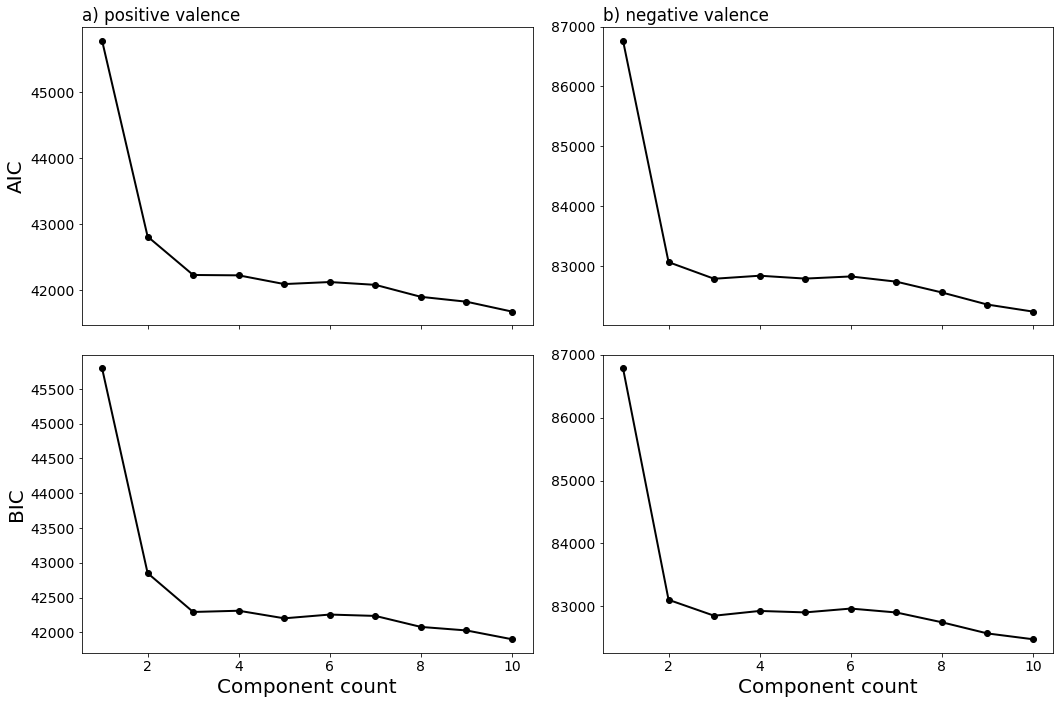

In [15]:
# load files into dataframes
pos_all = pd.read_csv("{}user_peak_zscores_mood=1_gender=all.txt".format(DATA_PATH), sep="\t", header=None)
neg_all = pd.read_csv("{}user_peak_zscores_mood=-1_gender=all.txt".format(DATA_PATH), sep="\t", header=None)

pos_all.columns = ["userID", "peakz"]
neg_all.columns = ["userID", "peakz"]

datasets = [pos_all["peakz"], neg_all["peakz"]]
labels = ['a) positive valence', 'b) negative valence']

plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams.update({'font.size': 14})

N = range(1,11)
fig, axes = plt.subplots(2,2, sharex=True)
for d, data in enumerate(datasets):
    aic, bic = list(), list()
    for i in N:
        gmm = GaussianMixture(n_components=i, covariance_type="full", tol=0.001)
        model = gmm.fit(X=np.expand_dims(data, 1))
        aic.append(model.aic(np.expand_dims(data,1)))
        bic.append(model.bic(np.expand_dims(data,1)))
    
    axes[0,d].plot(N, aic, 'o-', c='k', linewidth=2)
    axes[1,d].plot(N, bic, 'o-', c='k', linewidth=2)
    axes[0,d].set_title(labels[d], loc="left")
    axes[1,d].set_xlabel('Component count', fontsize=20)
    if d == 0:
        axes[0,d].set_ylabel('AIC', fontsize=20)
        axes[1,d].set_ylabel('BIC', fontsize=20)
    
plt.tight_layout()


main CI 1.096: 95%CI[-1.24,2.417]
a) positive valence C 1 : w= 0.7812310759194322 , N( 1.3141129423154265 , 0.31518808361901807 )
a) positive valence C 2 : w= 0.21876892408054685 , N( -0.4797641433759106 , 0.41279954601330776 )
main CI -1.073: 95%CI[-2.434,1.285]
b) negative valence C 1 : w= 0.3216466852607959 , N( 0.09833924003226549 , 0.7046804912693725 )
b) negative valence C 2 : w= 0.6783533147391965 , N( -1.4184776528853134 , 0.3438056362078494 )


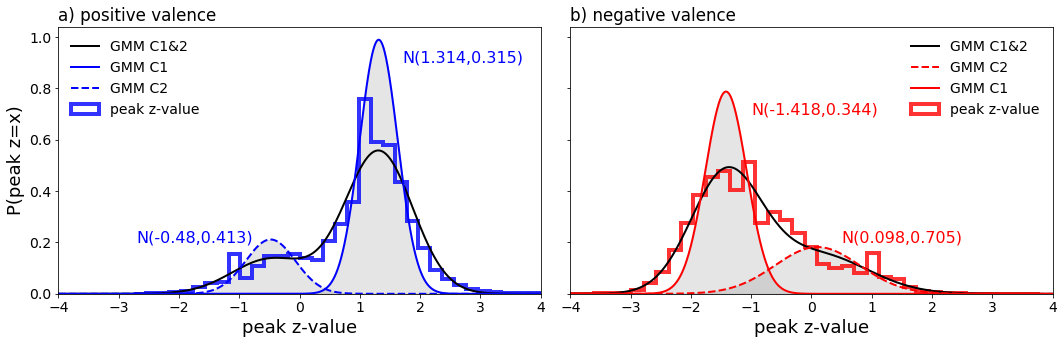

In [16]:

pos_all = pd.read_csv("{}user_peak_zscores_mood=1_gender=all.txt".format(DATA_PATH), sep="\t", header=None)
neg_all = pd.read_csv("{}user_peak_zscores_mood=-1_gender=all.txt".format(DATA_PATH), sep="\t", header=None)

pos_all.columns = ["userID", "peakz"]
neg_all.columns = ["userID", "peakz"]

plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams.update({'font.size': 14})

fig, axes = plt.subplots(1,2, sharey=True)

data_posneg = [pos_all["peakz"], neg_all["peakz"]]
color_choice = ["blue","red"]
labels = ["a) positive valence", "b) negative valence"]
textloc = {"neg_small":(0.5,0.20),"neg_large":(-1,0.7),"pos_large":(1.7,0.9),"pos_small":(-2.7,0.2)}
legdendloc = [1,2]

for i in range(len(axes)):

    data = data_posneg[i]
    color = color_choice[i]
    label = labels[i]
    
    axes[i].set_xlabel("peak z-value", fontsize=18)
    axes[i].set_title(label, loc="left")
    if i == 0:
        axes[i].set_ylabel("P(peak z=x)", fontsize=18)

    axes[i].set_xlim(-4,+4)

    # annotate with CI
    CIs = (np.percentile(data, 2.5),\
         np.percentile(data, 50),\
         np.percentile(data, 97.5))
    
    #print label, "95%CI: ", CIs
    main_curve_label = str(np.round(CIs[1],3)) + ": 95%CI[" +\
                       str(np.round(CIs[0],3)) + "," + str(np.round(CIs[2],3)) + "]"
    print("main CI", main_curve_label)
    
    # add GMM fit!
    gmm = GaussianMixture(n_components=2, covariance_type="full", tol=0.001)
    model = gmm.fit(X=np.expand_dims(data, 1))
    gmm_x = np.linspace(-6, +6, 5000)
    gmm_y = np.exp(model.score_samples(gmm_x.reshape(-1, 1)))
    
    # PLOT GMM (2 components combined)
    axes[i].plot(gmm_x, gmm_y, color="black", lw=2, label="GMM C1&2")

    # plot each separate component
    for c in range(2):
        weight = float(gmm.weights_[c])
        mean = float(gmm.means_[c])
        var = float(gmm.covariances_[c])
        
        Ntext = "N(" + str(np.round(mean,3)) + "," + str(np.round(var,3)) +")"
        
        # C1?
        if weight > 0.5:
            Clabel = "GMM C1"
            linet = "-"
            
            if "pos" in label:
                tlocx,tlocy = textloc["pos_large"]
            else:
                tlocx,tlocy = textloc["neg_large"]
                        
        else:
            Clabel = "GMM C2"
            linet = "--"
            
            if "pos" in label:
                tlocx,tlocy = textloc["pos_small"]
            else:
                tlocx,tlocy = textloc["neg_small"]
           
        # add GMM component annotation in the right place
        print(label, "C", c+1, ": w=", weight, ", N(", mean, ",", var, ")")
        axes[i].text(tlocx,tlocy, Ntext, fontsize=16, color=color )
        
        C1 = sp.stats.norm(mean,var)
        C1_pdf = [C1.pdf(j)*weight for j in gmm_x]
        axes[i].plot(gmm_x, C1_pdf, color=color, linewidth=2, label=Clabel, linestyle=linet)
        
        axes[i].fill_between(gmm_x, 0, C1_pdf, color="gray", alpha=0.2)
        
        # add vertical line
        #ax.axvline(x=mean, color=color, linewidth=1, linestyle=linet)
         
    ## PLOT MAIN HISTOGRAM
    p = axes[i].hist(data, bins=50, color=color, histtype = 'step', linewidth=4, normed=True, alpha=0.8, label="peak z-value")

    #ax.grid(True)
    axes[i].legend(frameon=False, prop={'size': 14})

plt.tight_layout()
#fig.savefig('figures/GMM_individual_peak_zvalue_distribution.pdf', bbox_inches='tight')
fig.savefig('figures/Fig5.pdf', bbox_inches='tight')


**Figure 5: Robustness analysis.** The distributions of peak z-scores of the valence time series for negative (a) and positive (b) emotions modeled by a 2-component Gaussian mixture model reveals that the majority of users exhibit a similar and significant emotional response matching the Valence of their self-report. Both emotions (a and b) show a second Gaussian Mixture Model component that may correspond to a small sub-sample where the sentiment analysis tool (VADER) returns zero, insignificant, or inverted sentiment scores.

In [12]:
# How many cases contrary to valence sign

# in positive emotion distribution how many < 0
Np0 = len(pos_all[pos_all["peakz"] < 0])
Np = len(pos_all)
print('\n ## Positive emotion distribution ##')
print("contrary cases: ", Np0)
print("total N:", Np)
print("% contrary:", float(Np0) / Np * 100)

# in negative emotion distribution how many > 0
Nn0 = len(neg_all[neg_all["peakz"] > 0])
Nn = len(neg_all)
print('\n ## Negative emotion distribution ##')
print("contrary cases: ", Nn0)
print("total N:", Nn)
print("% contrary:", float(Nn0) / Nn * 100)


 ## Positive emotion distribution ##
contrary cases:  3014
total N: 16846
% contrary: 17.891487593494006

 ## Negative emotion distribution ##
contrary cases:  5207
total N: 30998
% contrary: 16.79785792631783


# Discontinuity analysis

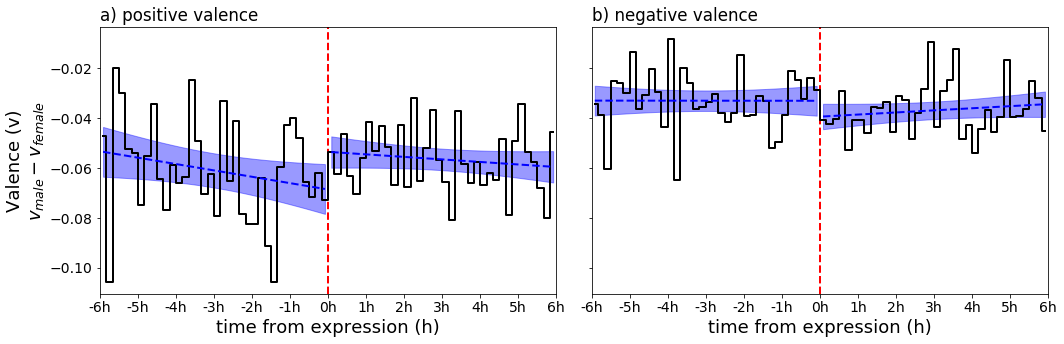

In [15]:
def ols_fitting(x, y):
    xc = sm.add_constant(x)
    model = sm.OLS(y, xc)
    fitted = model.fit()
    x_pred = np.linspace(x.min(), x.max(), 50)
    x_pred2 = sm.add_constant(x_pred)
    y_pred = fitted.predict(x_pred2)

    y_hat = fitted.predict(xc)
    y_err = y - y_hat
    mean_x = xc.T[1].mean()
    n = len(x)
    dof = n - fitted.df_model - 1
    t = stats.t.ppf(1-0.025, df=dof)
    s_err = np.sum(np.power(y_err, 2))
    conf = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((x_pred-mean_x),2) / ((np.sum(np.power(x_pred,2))) - n*(np.power(mean_x,2))))))
    upper = y_pred + abs(conf)
    lower = y_pred - abs(conf)
    return x_pred, y_pred, upper, lower
    
    
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams.update({'font.size': 14})

data = dict()
for fname in ['pos_female.txt', 'pos_male.txt', 'neg_female.txt', 'neg_male.txt']:
    data[fname.split('.')[0]] = pd.read_csv('{}{}'.format(DATA_PATH, fname), sep="\t")

labels = ["a) positive valence", "b) negative valence"]
fig, axarr = plt.subplots(1, 2, sharey=True)
for i in range(len(axarr)):
    dkey = 'pos' if i == 0 else 'neg'
    
    axarr[i].set_xlim([-19800, 21600])
    axarr[i].set_xlabel("time from expression (h)", fontsize=18)
    axarr[i].axvline(x=0, color="red", linestyle="--", linewidth=2)
    if i == 0:
        axarr[i].set_ylabel("Valence (v)\n" + r"$v_{male} - v_{female}$", fontsize=18)
        
    plt.sca(axarr[i])
    plt.xticks([i*60*60 for i in range(-6,7)], [str(i)+'h' for i in range(-6,7)])
    
    # valence bands and lines
    xvals = np.array(data['{}_male'.format(dkey)]["window"])
    yvals = np.array(data['{}_male'.format(dkey)]["vader_50p"]-data['{}_female'.format(dkey)]["vader_50p"])
    axarr[i].step(xvals, yvals, color="black", linewidth=2, label="observed 50p", where="mid")

    idx = int(np.where(xvals==300)[0])
    x_pred, y_pred, upper, lower = ols_fitting(xvals[:idx], yvals[:idx])
    axarr[i].plot(x_pred, y_pred, 'b--', linewidth=2)
    axarr[i].fill_between(x_pred, lower, upper, color='b', alpha=0.4)

    x_pred, y_pred, upper, lower = ols_fitting(xvals[idx:], yvals[idx:])
    axarr[i].plot(x_pred, y_pred, 'b--', linewidth=2)
    axarr[i].fill_between(x_pred, lower, upper, color='b', alpha=0.4)

    axarr[i].set_title(labels[i], loc="left")

fig.tight_layout()
#fig.savefig('figures/gender_temporal_difference_10m.pdf', bbox_inches='tight')
fig.savefig('figures/Fig7.pdf', bbox_inches='tight')


**Figure 7: Regression discontinuity analysis of male and female time series in negative and positive affect labeling groups.** We plot the difference between male ($v_{male}$) and female ($v_{female}$) valence time series of mean valence values at 10 minute intervals for positive (panel a) and negative (panel b) valence. A regression discontinuity analysis applied to the resulting $v_{male} − v_{female}$ time series shows a divergence between male and female responses at time $t_0$ for both positive and negative affect labeling groups (panel a and panel b respectively) . Blue bands show the 95% confidence intervals of the linear regression estimates.

# Word selection analysis

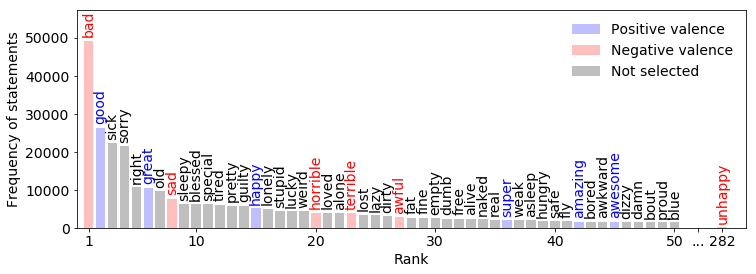

In [17]:
selectedWords = set()
wordCounts = dict()
posList, negList = {'good', 'happy', 'great', 'awesome'}, {'bad', 'unhappy', 'sad','terrible', 'horrible', 'awful'}

with open('{}top50_keywords.txt'.format(DATA_PATH),'r') as fl:
    for line in fl:
        temp = line.strip().split()
        wordCounts[temp[1]] = int(temp[0])
        if temp[2] == 'y':
            selectedWords.add(temp[1])

            
fig = plt.figure(figsize=(12,4))
barlist = plt.bar(list(range(1,len(wordCounts)+1))+[54], 
                  [wordCounts[w] for w in sorted(wordCounts, key=wordCounts.get, reverse=True)]+[116],
                  alpha=0.25, facecolor='k', linewidth=0)

for i,w in enumerate(sorted(wordCounts, key=wordCounts.get, reverse=True)):
    tcolor = 'k'
    if w in selectedWords:
        tcolor = 'r' if w in negList else 'b'
        barlist[i].set_color(tcolor)
        
    plt.text(i+1, wordCounts[w]+1000, w, rotation=90, va='bottom', ha='center', color=tcolor)
barlist[-1].set_color('r')
plt.text(54, 116+1000, 'unhappy', rotation=90, va='bottom', ha='center', color='r')
plt.xticks([1, 10, 20, 30, 40, 50, 52, 54], ['1', '10', '20', '30', '40', '50', '...', '282'])
    
plt.xlabel('Rank', fontsize=14)
plt.ylabel('Frequency of statements', fontsize=14)
plt.xlim((0,56))
plt.ylim(ymax=max(wordCounts.values())+8000)
plt.tick_params(axis='both', labelsize=14)

lgnd = [Patch(facecolor='b', alpha=0.25, label='Positive valence'),
        Patch(facecolor='r', alpha=0.25, label='Negative valence'),
        Patch(facecolor='k', alpha=0.25, label='Not selected')]

plt.legend(handles=lgnd, fontsize=14, frameon=False)

#fig.savefig('figures/keyword_ranking.pdf', bbox_inches='tight')
fig.savefig('figures/FigS1.pdf', bbox_inches='tight')

**Supplementary Figure 1** Ranking of the selected words. "I feel " adjectives rank-ordered according to their frequency of occurrence. Two annotators selected 10 adjectives that most unambiguously identified a low or high valence emotion, without connoting other more specific emotions ("sorry", "stupid", "weird"), physical states ("sick", "old"), figurative uses ("naked", "empty"), or having alternate uses as modifiers ("like", "pretty"). The positive and negative adjectives we identified are respectively shown in blue and red colors. Adjectives and other keywords that were not selected for the reasons above are show in gray.